In [51]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from preprocess.py12_spike_data_preprocess_utils import spiketimes_to_spikecounts

In [52]:
# ---------- Load Data ----------
path = "../data/new_data_mini/session_057_aligned_spike_times.pkl"
with open(path, 'rb') as f:
    data = pkl.load(f)

# 数据中LR表示的是正确答案是L, 但实际上小鼠舔了右侧
# 数据的顺序是neuron index, trial_num, spikes


In [ ]:
brain_region = 'right ALM'
data_single = data['RR'][brain_region]

num_neurons, num_trials = len(data_single), len(data_single[0])
time_epochs = [(-3.0, 2.0)] * num_trials
print(f"Number of neurons: {num_neurons}, Number of trials: {num_trials}")


Number of neurons: 151, Number of trials: 206


In [54]:
# 找到LL, RR中在一定时间段内平均发放率差异最大的神经元
time_window = (-1.2, 0.0)  # 选择时间段

ratio_list = []
for neuron_id in range(num_neurons):
    data_LL = data['LL'][brain_region]
    num_trials = len(data_LL[0])
    time_epochs = [(-3.0, 2.0)] * num_trials
    
    spike_sum_LL = 0
    for trial in range(num_trials):
        spike_times = data_LL[neuron_id][trial]
        spike_count = np.sum((spike_times >= time_window[0]) & (spike_times < time_window[1]))
        spike_sum_LL += spike_count
    avg_rate_LL = spike_sum_LL / (num_trials * (time_window[1] - time_window[0]))

    data_RR = data['RR'][brain_region]
    num_trials = len(data_RR[0])
    time_epochs = [(-3.0, 2.0)] * num_trials   
    spike_sum_RR = 0
    for trial in range(num_trials):
        spike_times = data_RR[neuron_id][trial]
        spike_count = np.sum((spike_times >= time_window[0]) & (spike_times < time_window[1]))
        spike_sum_RR += spike_count
    avg_rate_RR = spike_sum_RR / (num_trials * (time_window[1] - time_window[0]))
    
    if avg_rate_LL == 0 or avg_rate_RR == 0:
        ratio_list.append(0)
    else:
        ratio_list.append(max(avg_rate_LL / avg_rate_RR, avg_rate_RR / avg_rate_LL))

# 对ratio_list进行排序，找到差异最大的神经元
sorted_indices = np.argsort(np.array(ratio_list) - 1)[::-1]

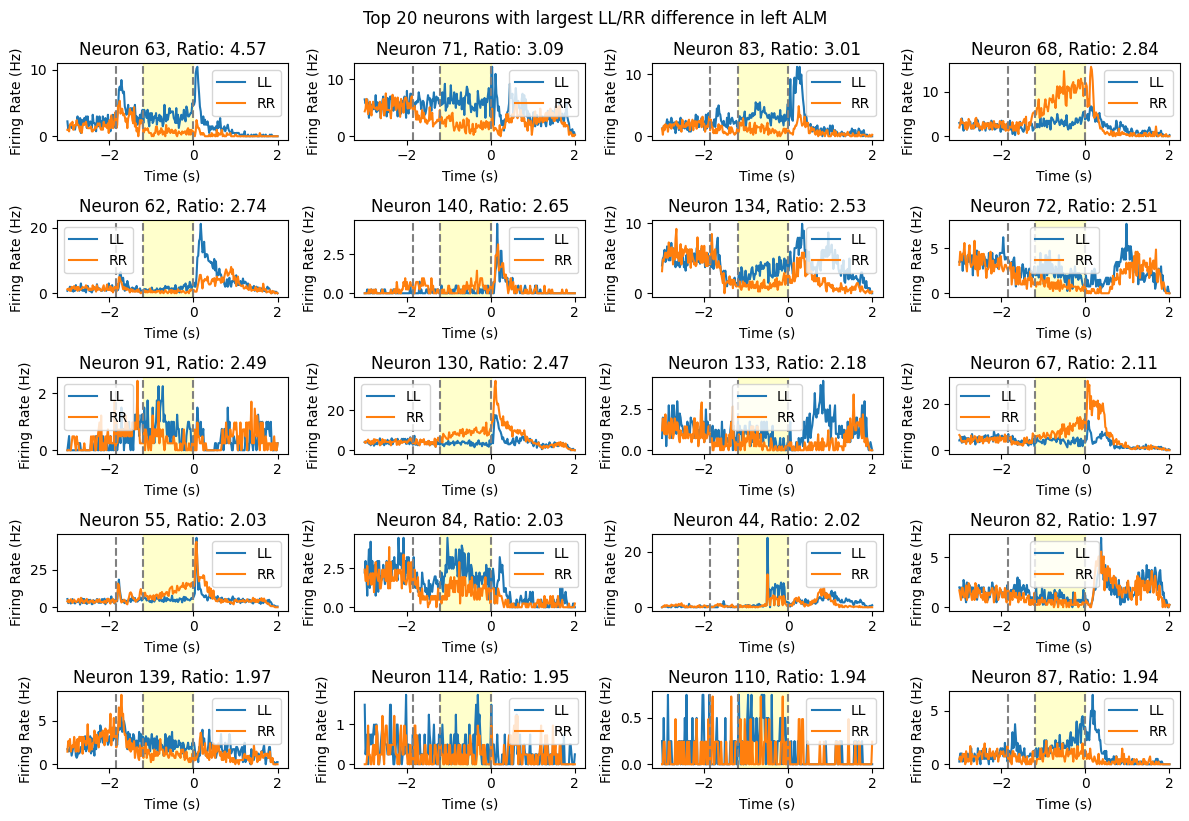

In [55]:
# 使用subplots画出两种条件下差异最大的神经元的平均发放率
choices = ['LL', 'RR']
num_top_neurons = 20  # 显示差异最大的几个神经元
top_neurons = sorted_indices[:num_top_neurons]

fig, axes = plt.subplots(5, 4, figsize=(12, 8))
axes = axes.flatten()

plot_band = False
for i, neuron_idx in enumerate(top_neurons):
    ax = axes[i]
    for choice in choices:
        data_single = data[choice][brain_region]
        num_trials = len(data_single[0])
        time_epochs = [(-3.0, 2.0)] * num_trials
        spike_counts = spiketimes_to_spikecounts(data_single, time_epochs)
        spike_counts_reshape_ori = spike_counts.reshape((-1, num_trials, num_neurons), order='F')
        spike_counts_avg = spike_counts_reshape_ori.mean(axis=1) * 1/0.02
        spike_counts_std = spike_counts_reshape_ori.std(axis=1) * 1/0.02
        
        ax.plot(np.linspace(-3, 2, 250), spike_counts_avg[:, neuron_idx], label=choice)
        if plot_band:
            ax.fill_between(np.linspace(-3, 2, 250),
                           spike_counts_avg[:, neuron_idx] - spike_counts_std[:, neuron_idx],
                           spike_counts_avg[:, neuron_idx] + spike_counts_std[:, neuron_idx],
                           alpha=0.25, label=f'{choice} ±1 std')
    
    ax.axvline(x=0, color='grey', linestyle='--')
    ax.axvline(x=-1.85, color='grey', linestyle='--')
    ax.axvline(x=-1.2, color='grey', linestyle='--')
    ax.axvspan(-1.2, 0, alpha=0.2, color='yellow')  # 标记比较的时间窗口
    ax.legend()
    ax.set_title(f'Neuron {neuron_idx}, Ratio: {ratio_list[neuron_idx]:.2f}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing Rate (Hz)')

plt.tight_layout()
plt.suptitle(f'Top {num_top_neurons} neurons with largest LL/RR difference in {brain_region}', y=1.02)
plt.show()

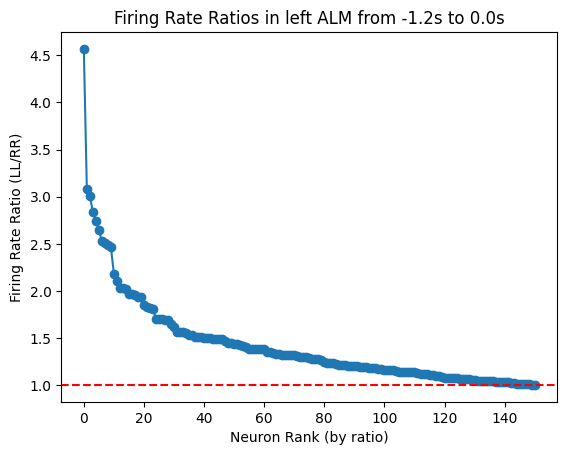

In [56]:
# 画出比值随着indices变化的图
plt.figure()
plt.plot(np.arange(len(ratio_list)), np.array(ratio_list)[sorted_indices], marker='o')
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel('Neuron Rank (by ratio)')
plt.ylabel('Firing Rate Ratio (LL/RR)')
plt.title(f'Firing Rate Ratios in {brain_region} from {time_window[0]}s to {time_window[1]}s')
plt.show()